# I_t : Calcium-independent Transient Outward K+ Current 

## 1.0 Setup

In [92]:
# Import packages and constants
import os
import sys 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'Python File')))


In [93]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from constants import  R, T, F,g_t,E_K,K_o,K_i

# Weird bug where the E_K is not following what is in the constants file
E_K = (R * T / F) * np.log(K_o / K_i)
print(E_K)


-82.61398354198526


In [94]:

def dr_dt(t, r, V):
    r_infinity = 1 / (1 + np.exp((V + 10.6) / -11.42))
    tau_r = 1 / (45.16 * np.exp(0.03577 * (V + 50)) + 98.9 * np.exp(-0.1 * (V + 38)))
    return (r_infinity - r) / tau_r

def ds_dt(t, s, V):
    s_infinity = 1 / (1 + np.exp((V + 45.3) / 6.8841))
    tau_s_endo = 0.55 * np.exp(-((V + 70) / 25)**2) + 0.049
    return (s_infinity - s) / tau_s_endo

def ds_slow_dt(t, s_slow, V):
    s_slow_infinity = 1 / (1 + np.exp((V + 45.3) / 6.8841))
    tau_s_slow_endo = 3.3 * np.exp(-((V + 70) / 30)**2) + 0.049
    return (s_slow_infinity - s_slow) / tau_s_slow_endo


def i_t_current(V,g_t,E_K,diabetes):
    
    # Diabetic adjustments
    if diabetes:
        g_t = 0.68 * g_t
        b = 0.31
    else:
        b = 0.114
    a = 1 - b

    # Initial values
    r0 = 0.002191519
    s0 = 0.9842542
    s_slow0 = 0.6421196

    # time values
    end_time = 20
    t_span = (0, end_time)  
    t_eval = np.linspace(0, end_time, 1000) 

    # Solving
    r_solution = solve_ivp(dr_dt, t_span, [r0], args=(V,), t_eval=t_eval, method='RK45')
    s_solution = solve_ivp(ds_dt, t_span, [s0], args=(V,), t_eval=t_eval, method='RK45')
    s_slow_solution = solve_ivp(ds_slow_dt, t_span, [s_slow0], args=(V,), t_eval=t_eval, method='RK45')

    # Extract the values at each time step
    r_values = r_solution.y[0]
    s_values = s_solution.y[0]
    s_slow_values = s_slow_solution.y[0]

    # Compute I_t at each time step and find the maximum value
    i_t_values = g_t * r_values * (a * s_values + b * s_slow_values) * (V - E_K)
    i_t_peak = np.max(i_t_values)
    return i_t_peak

## 2.0 Solving

In [98]:
V_range = np.linspace(-60, 60, 20)

### 2.1 Healthy Cell


In [99]:
diabetes = 0

# Initialising arrays 
i_t_peak_values = []

for V in V_range:
    i_t_peak =  i_t_current(V,g_t,E_K,diabetes)
    i_t_peak_values.append(i_t_peak)


### 2.2 Diabetes

In [102]:
diabetes = True

# Initialising arrays 
i_t_peak_diabetic_values = []

# Solving 
for V in V_range:
    i_t_peak =  i_t_current(V,g_t,E_K,diabetes)
    i_t_peak_diabetic_values.append(i_t_peak)


In [106]:
# Normalising values to get current density
C = 100e-6 #microfarads
normalised_healthy_i_t = np.array(i_t_peak_values) * 1e-3 / C
normalised_diabetic_i_t = np.array(i_t_peak_diabetic_values) * 1e-3 / C

## 3.0 Plotting

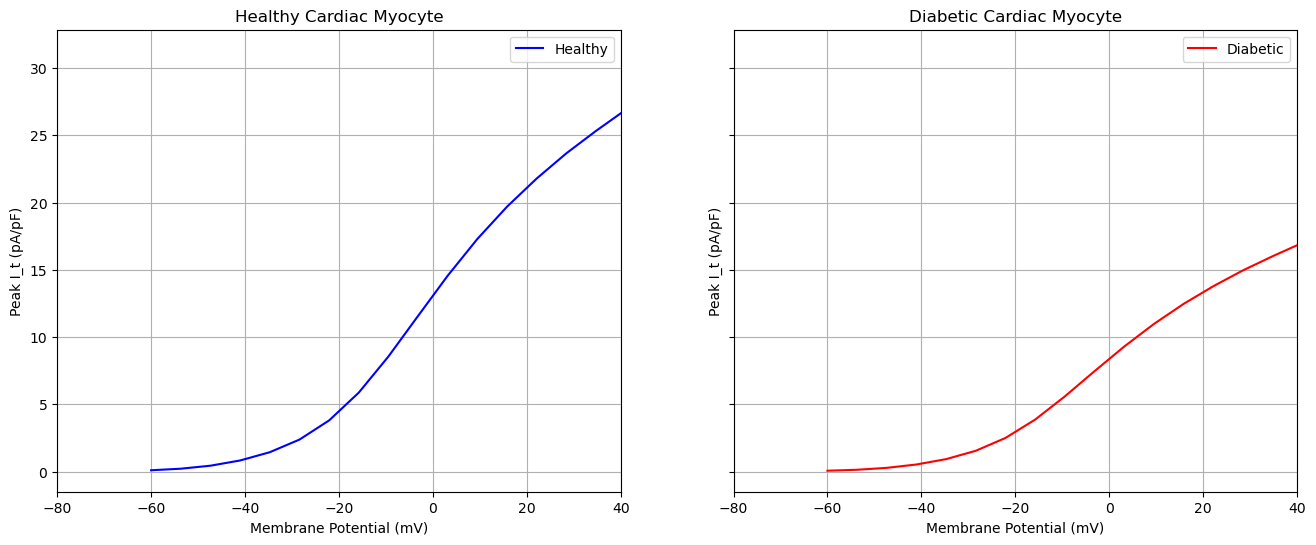

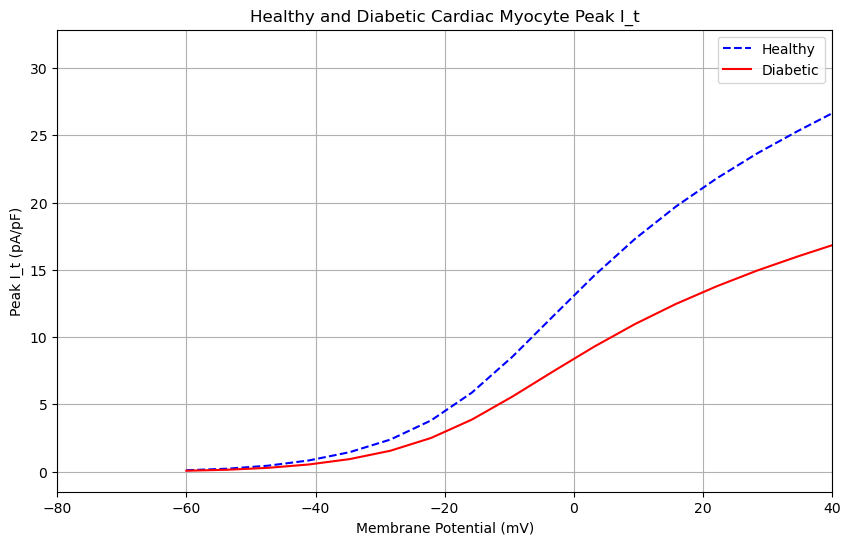

In [110]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#  healthy I_t values
axs[0].plot(V_range, normalised_healthy_i_t, label='Healthy', color='blue')
axs[0].set_xlim(-80, 40)
axs[0].set_xlabel('Membrane Potential (mV)')
axs[0].set_ylabel('Peak I_t (pA/pF)')
axs[0].set_title('Healthy Cardiac Myocyte')
axs[0].legend()
axs[0].grid(True)

#  diabetic I_t values
axs[1].plot(V_range, normalised_diabetic_i_t, label='Diabetic', color='red')
axs[1].set_xlim(-80, 40)
axs[1].set_xlabel('Membrane Potential (mV)')
axs[1].set_ylabel('Peak I_t (pA/pF)')
axs[1].set_title('Diabetic Cardiac Myocyte')
axs[1].legend()
axs[1].grid(True)

# Combined plot 
plt.figure(figsize=(10, 6))
plt.plot(V_range, normalised_healthy_i_t, label='Healthy', color='blue', linestyle='--')
plt.plot(V_range, normalised_diabetic_i_t, label='Diabetic', color='red')
plt.xlim(-80, 40)
plt.xlabel('Membrane Potential (mV)')
plt.ylabel('Peak I_t (pA/pF)')
plt.title('Healthy and Diabetic Cardiac Myocyte Peak I_t')
plt.legend()
plt.grid(True)
plt.show()